## <div align=center>Diversity vs. Human Development Analysis Project</div>
### <div align=center>Connor Collins, Andrew Nguyen</div>
### <div align=center>OMIS 114</div>
### <div align=center>1 December 2020</div>

### <div align=center>In western civilization, is often said by various activists, pundits and politicians that "diversity is our strength," implying that a higher level of diversity in a given nation is indicative or a contributing factor to economic prosperity and/or a higher standard of living.  This study will attempt to examine the truth of such a claim by comparing UN Human Development Index (HDI) data of a given nation with their level of ethnic diversity (measured in Ethnic Fractionalization Index or EFI) to see if there is any correlation.  Afterwards, we will compare EFI with the each individual subcomponent of HDI (such as Economy, Education, to name a few) to see if there are any correlations in specific aspects of HDI. Additionally we will compare EFI with a country's level of happiness (UN Happiness Index) as we believe collective happiness ought to be a factor in a country's quality of life.  </div>

In [528]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style
import matplotlib.ticker as ticker
import matplotlib as mpl
from functools import reduce
pd.set_option('display.max_rows', None, 'display.max_columns', None)

## Loading the Data

### Summary of data used in this project (in order of invocation):

###### <u>United Nations Data:</u>
<ul>
    <li>      <b>Human Development Index (HDI)</b>:  measures a country's level of human development as a composite of the variables below (Higher = Better)<br>
        <ul><li>       <b>Schooling Years</b>:  measures the average length of schooling for a given country (Higher = Better)<br>
            <li>       <b>Exports + Imports</b>:  measures openess to trade by summing a country's Exports and Imports as a percentage of their GDP ((Higher = Better)<br>
            <li>       <b>Gender Development Index</b>: measures the HDI-sex-gap using a ratio between Males-only HDI and Females-only HDI (Lower = Better)<br>
 <li>      <b>Gross National Income (per capita)</b>: aka Purchasing Power Parity (PPP), GNI measures the spending power of an average person in a given country in raw dollar terms (Higher = Better)<br>
 <li>     <b>Inequality-adjusted HDI</b>: measures inequality by producing an HDI score adjusted for inequality (Higher = Better)<br>
 <li>       <b>Internet Users</b>: measures mobility and communication through the percentage of people who have internet access (Higher = Better)<br>
 <li>       <b>Life Expectancy</b>:  measures human security through the average life expectancy of a country (Higher = Better)<br>
 <li>      <b>Population</b>:  measures demography via the total population of a country in millions (Higher = More Crowded)<br>
 <li>       <b>Skilled Labor</b>: measures socio-economic stability by seeing how much of the labor force is skilled (Higher = Better)<br>
 <li>      <b>Employment</b>: measures the percentage of the population that is employed (Higher = Better, mostly)<br>
 <li>       <b>Homicide Rate</b>: measures human security by capturing the number of homicides per 100k people (Lower = Better)<br>
 <li>      <b>World Happiness Report</b>: measures a country's level of self-reported happiness (Higher = Better)<br>
     </ul>
</ul>

##### <u>Harvard Data:</u>
<ul>
    <li> <b>Historical Index of Ethnic Fractionalization (HIEF)</b>: measures a country's level of diversity (Higher score = More diverse) <br>
<ul>

In [565]:
hdi=pd.read_csv('Human Development Index (HDI).csv')
hief_data=pd.read_csv('HIEF_data.csv')

schooling_years=pd.read_csv('Expected years of schooling (years).csv')
exports_imports=pd.read_csv('Exports and imports (% of GDP).csv')
gender_development=pd.read_csv('Gender Development Index (GDI).csv')
gni_per_capita=pd.read_csv('Gross national income (GNI) per capita (2011 PPP$).csv')
homicide_rate=pd.read_csv('Homicide rate (per 100,000 people).csv')
inequality=pd.read_csv('Inequality-adjusted HDI (IHDI).csv')
internet_users=pd.read_csv('Internet users, total (% of population).csv')
life_exp=pd.read_csv('Life expectancy at birth.csv')
population=pd.read_csv('Population, total (millions).csv')
skilled_labor=pd.read_csv('Skilled labour force (% of labour force).csv')
employment=pd.read_csv('Employment to population ratio (% ages 15 and older).csv')

whr=pd.read_excel('WHR20_DataForFigure2.1.xls')

data_frames=[schooling_years, exports_imports, gender_development, gni_per_capita, homicide_rate, inequality, 
            internet_users, life_exp, population, skilled_labor, employment]

In [530]:
hief_data=hief_data.loc[hief_data['Year']==2013]

## Cleaning

In [531]:
def fix_csv(csv):
    csv.reset_index(inplace=True)
    new_headers=csv.iloc[0]
    csv.columns=new_headers
    csv.drop(index=0, inplace=True)
    csv=csv.loc[:, csv.columns.notnull()]
    csv=csv.loc[csv['2013']!='..'] # for some reason this also doesn't work inside the function
    #csv.dropna(axis=0, inplace=True)
    
def clean_columns(csv):
    #can't seem to get this to work in a function - gonna do it manually for now, will try to fix later
    csv=csv.loc[:, csv.columns.notnull()]

In [532]:
fix_csv(schooling_years)
fix_csv(exports_imports)
fix_csv(gender_development)
fix_csv(gni_per_capita)
fix_csv(homicide_rate)
fix_csv(inequality)
fix_csv(internet_users)
fix_csv(life_exp)
fix_csv(population)
fix_csv(skilled_labor)
fix_csv(employment)
fix_csv(hdi)

Problem: Dataframes pertaining to HDI and HDI subcomponents have lots of useless data under Zimbabwe

Assumptions:
<ul>
<li>All UN HDI dataframes already arranged their countries in alphabetical order
<li>Zimbabwe should, therefore, always be the last data entry in any HDI-related dataframe
</ul>

Solution: Make a function that captures the index of a given DataFrame's 'Zimbabwe' entry and drop every entry after it

In [533]:
## .index on a DataFrame returns an int64, which can't be used in index range operations.
## We must thus convert the int64 into an int.
## Using .tolist()[0] effectively achieves this.
## We now have a new function that cleans up HDI data after Zimbabwe.

def zim_index_drop(df):
    zim_index = df[df.Country == 'Zimbabwe'].index.tolist()[0]
    df = df.drop(df.index[(zim_index + 1):], inplace=True)
    
def zim_index_find(df):
    zim_index = df[df.Country == 'Zimbabwe'].index.tolist()[0]
    return zim_index

In [534]:
zim_index_drop(hdi)
zim_index_drop(schooling_years)
zim_index_drop(exports_imports)
zim_index_drop(gender_development)
zim_index_drop(gni_per_capita)
zim_index_drop(homicide_rate)
zim_index_drop(inequality)
zim_index_drop(internet_users)
zim_index_drop(life_exp)
zim_index_drop(population)
zim_index_drop(skilled_labor)
zim_index_drop(employment)

In [535]:
hdi = hdi.loc[:, hdi.columns.notnull()].loc[hdi['2013']!='..'].loc[hdi['2018']!='..'][['HDI Rank (2018)', 'Country', '2013', '2018']]
schooling_years = schooling_years.loc[:, schooling_years.columns.notnull()].loc[schooling_years['2013']!='..'].loc[schooling_years['2018']!='..'][['HDI Rank (2018)', 'Country', '2013', '2018']]
exports_imports = exports_imports.loc[:, exports_imports.columns.notnull()].loc[exports_imports['2013']!='..'].loc[exports_imports['2018']!='..'][['HDI Rank (2018)', 'Country', '2013', '2018']]
gender_development = gender_development.loc[:, gender_development.columns.notnull()].loc[gender_development['2013']!='..'].loc[gender_development['2018']!='..'][['HDI Rank (2018)', 'Country', '2013', '2018']]
gni_per_capita = gni_per_capita.loc[:, gni_per_capita.columns.notnull()].loc[gni_per_capita['2013']!='..'].loc[gni_per_capita['2018']!='..'][['HDI Rank (2018)', 'Country', '2013', '2018']]
homicide_rate = homicide_rate.loc[:, homicide_rate.columns.notnull()].loc[homicide_rate['2013']!='..'].loc[homicide_rate['2017']!='..'][['HDI Rank (2018)', 'Country', '2013', '2017']]
inequality = inequality.loc[:, inequality.columns.notnull()].loc[inequality['2013']!='..'].loc[inequality['2018']!='..'][['HDI Rank (2018)', 'Country', '2013', '2018']]
internet_users = internet_users.loc[:, internet_users.columns.notnull()].loc[internet_users['2013']!='..'].loc[internet_users['2018']!='..'][['HDI Rank (2018)', 'Country', '2013', '2018']]
life_exp = life_exp.loc[:, life_exp.columns.notnull()].loc[life_exp['2013']!='..'].loc[life_exp['2018']!='..'][['HDI Rank (2018)', 'Country', '2013', '2018']]
population = population.loc[:, population.columns.notnull()].loc[population['2013']!='..'].loc[population['2018']!='..'][['HDI Rank (2018)', 'Country', '2013', '2018']]
skilled_labor = skilled_labor.loc[:, skilled_labor.columns.notnull()].loc[skilled_labor['2013']!='..'].loc[skilled_labor['2018']!='..'][['HDI Rank (2018)', 'Country', '2013', '2018']]
employment = employment.loc[:, employment.columns.notnull()].loc[employment['2013']!='..'].loc[employment['2018']!='..'][['HDI Rank (2018)', 'Country', '2013', '2018']]

Naming Convention for UN Data:

 hdi:      Human Development Index score <br>
 sy:       Schooling Years <br>
 ei:       Exports + Imports (percentage of GDP) <br>
 gd:       Gender Development Index<br>
 gni:      Gross National Income (per capita)<br>
 ineq:     Inequality-adjusted HDI<br>
 iu:       Internet Users (as % of pop)<br>
 le:       Life Expectancy<br>
 pop:      Population<br>
 sl:       Skilled Labor (as % of labor force)<br>
 emp:      Employment (ratio to pop)<br>
 hr:       Homicide Rate<br>
 

In [536]:
hdi.rename(columns={'2013':'hdi_2013', '2018':'hdi_2018'}, inplace=True)
schooling_years.rename(columns={'2013':'sy_2013', '2018':'sy_2018'}, inplace=True)
exports_imports.rename(columns={'2013':'ei_2013', '2018':'ei_2018'}, inplace=True)     
gender_development.rename(columns={'2013':'gd_2013', '2018':'gd_2018'}, inplace=True)
gni_per_capita.rename(columns={'2013':'gni_2013', '2018':'gni_2018'}, inplace=True)
inequality.rename(columns={'2013':'ineq_2013', '2018':'ineq_2018'}, inplace=True)
internet_users.rename(columns={'2013':'iu_2013', '2018':'iu_2018'}, inplace=True)
life_exp.rename(columns={'2013':'le_2013', '2018':'le_2018'}, inplace=True)
population.rename(columns={'2013':'pop_2013', '2018':'pop_2018'}, inplace=True)
skilled_labor.rename(columns={'2013':'sl_2013', '2018':'sl_2018'}, inplace=True)
employment.rename(columns={'2013':'emp_2013', '2018':'emp_2018'}, inplace=True)
homicide_rate.rename(columns={'2013':'hr_2013', '2017':'hr_2018'}, inplace=True)
#There is no data for 2018 in homicide_rate so I think it makes the most sense to just use 2017 for 2018

In [537]:
hief_data=hief_data[['Country', 'EFindex']]

In [538]:
hief_data = hief_data.rename(columns={"EFindex":"EFIndex_2013"})

In [539]:
## This sorts the countries by alphabetical order, to better align the datasets
hief_data = hief_data.sort_values('Country')

In [540]:
## This resets the index numbering of the dataset by creating an additional column to the left.
hief_data = hief_data.reset_index()

In [541]:
## This deletes the old index column
hief_data = hief_data.drop(columns=['index'])

In [542]:
## Clean
hief_data

,Country,EFIndex_2013
0,Afghanistan,0.763
1,Albania,0.139
2,Algeria,0.372
3,Angola,0.779
4,Argentina,0.158
5,Armenia,0.045
6,Australia,0.276
7,Austria,0.248
8,Azerbaijan,0.122
9,Bahrain,0.582


In [543]:
hdi

,HDI Rank (2018),Country,hdi_2013,hdi_2018
1,170,Afghanistan,0.485,0.496
2,69,Albania,0.781,0.791
3,82,Algeria,0.746,0.759
4,36,Andorra,0.846,0.857
5,149,Angola,0.547,0.574
6,74,Antigua and Barbuda,0.767,0.776
7,48,Argentina,0.824,0.830
8,81,Armenia,0.743,0.760
9,6,Australia,0.926,0.938
10,20,Austria,0.896,0.914


# Analysis #1:  EFI vs. HDI

In [544]:
## using 'inner' will merge all matching country names AND remove ALL NaN's
## using 'outer' will merge all matching countries and add additional rows for non-matching ones, resulting in many NaN's
hdi_w_hief=hdi.merge(hief_data, how='outer')

In [545]:
## Scroll to the bottom after index 188 to see a problem
hdi_w_hief

,HDI Rank (2018),Country,hdi_2013,hdi_2018,EFIndex_2013
0,170,Afghanistan,0.485,0.496,0.763
1,69,Albania,0.781,0.791,0.139
2,82,Algeria,0.746,0.759,0.372
3,36,Andorra,0.846,0.857,NaN
4,149,Angola,0.547,0.574,0.779
5,74,Antigua and Barbuda,0.767,0.776,NaN
6,48,Argentina,0.824,0.830,0.158
7,81,Armenia,0.743,0.760,0.045
8,6,Australia,0.926,0.938,0.276
9,20,Austria,0.896,0.914,0.248


In [546]:
hdi_w_hief.isna().sum()

HDI Rank (2018)    25
Country             0
hdi_2013           25
hdi_2018           25
EFIndex_2013       57
dtype: int64

#### Here we encountered a problem pertaining to naming discrepencies between the EFI data and the UN data.  Here we take an aside from the current analysis at hand in order to fix this problem for our subsequent analysis

In [547]:
## Here the zim_index functions come in handy once again, this time to capture the naming-error countries
lostnats = hdi_w_hief.iloc[zim_index_find(hdi_w_hief) + 1:]

In [548]:
## Out of the 57 countries that are NaN-ed, 25 of them should NOT be
len(lostnats)

25

In [549]:
## This is all the countries we lost due to naming discrepencies between the two datasets.
lostnats

,HDI Rank (2018),Country,hdi_2013,hdi_2018,EFIndex_2013
188,NaN,Bolivia,NaN,NaN,0.572
189,NaN,Bosnia-Herzegovina,NaN,NaN,0.637
190,NaN,Cape Verde,NaN,NaN,0.442
191,NaN,Cote d'Ivoire,NaN,NaN,0.731
192,NaN,Czech Republic,NaN,NaN,0.262
193,NaN,Democratic People's Republic of Korea,NaN,NaN,0.020
194,NaN,Democratic Republic of Congo,NaN,NaN,0.700
195,NaN,Democratic Republic of Vietnam,NaN,NaN,0.263
196,NaN,East Timor,NaN,NaN,0.802
197,NaN,German Federal Republic,NaN,NaN,0.189


In [550]:
## Here we generate the lists of country names to be renamed
EFI_names = lostnats.Country.tolist()
UN_names = ["Bolivia (Plurinational State of)", "Bosnia and Herzegovina", 
            "Cabo Verde", "Côte d'Ivoire", "Czechia", "EXCLUDE NORTH KOREA", 
            "Congo (Democratic Republic of the)", "Viet Nam", "Timor-Leste", 
            "Germany", "Iran (Islamic Republic of)", "Kyrgyzstan", "Lao People's Democratic Republic", 
            "North Macedonia", "Moldova (Republic of)", "Korea (Republic of)", "Russian Federation", 
            "EXCLUDE SOMALIA", "Eswatini (Kingdom of)", "Syrian Arab Republic", 
            "No Taiwan...suspicious *cough*China*cough*", "Tanzania (United Republic of)", 
            "United States", "Venezuela (Bolivarian Republic of)", "Yemen"]

In [551]:
## Here we verify that the number of EFI countries to be renamed total 25
len(EFI_names)

25

In [552]:
## Here we verify that the number of UN countries total 25
len(UN_names)

25

In [553]:
## Here the EFI countries are being renamed to conform with the UN naming conventions.
hief_data_renamed = hief_data.replace(EFI_names, UN_names)

In [554]:
## This will be the hief_data being used going forward
hief_data_renamed

,Country,EFIndex_2013
0,Afghanistan,0.763
1,Albania,0.139
2,Algeria,0.372
3,Angola,0.779
4,Argentina,0.158
5,Armenia,0.045
6,Australia,0.276
7,Austria,0.248
8,Azerbaijan,0.122
9,Bahrain,0.582


In [555]:
hdi_w_hief = hdi.merge(hief_data_renamed, how='outer')

In [556]:
hdi_w_hief = hdi_w_hief.dropna()

In [557]:
hdi_w_hief

,HDI Rank (2018),Country,hdi_2013,hdi_2018,EFIndex_2013
0,170,Afghanistan,0.485,0.496,0.763
1,69,Albania,0.781,0.791,0.139
2,82,Algeria,0.746,0.759,0.372
4,149,Angola,0.547,0.574,0.779
6,48,Argentina,0.824,0.830,0.158
7,81,Armenia,0.743,0.760,0.045
8,6,Australia,0.926,0.938,0.276
9,20,Austria,0.896,0.914,0.248
10,87,Azerbaijan,0.741,0.754,0.122
12,45,Bahrain,0.807,0.838,0.582


#### Iteration #1:  EFI 2013 vs HDI 2018

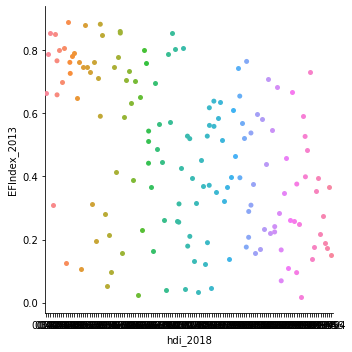

In [558]:
sns.catplot(data=hdi_w_hief, x='hdi_2018', y='EFIndex_2013')

#### Iteration #2: EFI 2013 vs HDI 2013

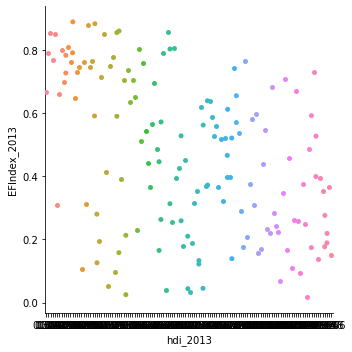

In [559]:
sns.catplot(data=hdi_w_hief, x='hdi_2013', y='EFIndex_2013')

# Analysis #2: EFI vs Years of Schooling (SY)

In [560]:
sy_w_hief = schooling_years.merge(hief_data_renamed, how='outer')

In [561]:
sy_w_hief

,HDI Rank (2018),Country,sy_2013,sy_2018,EFIndex_2013
0,170,Afghanistan,10.2,10.1,0.763
1,69,Albania,15.4,15.2,0.139
2,82,Algeria,14.3,14.7,0.372
3,36,Andorra,13.1,13.3,NaN
4,149,Angola,10.3,11.8,0.779
5,74,Antigua and Barbuda,12.8,12.5,NaN
6,48,Argentina,17.1,17.6,0.158
7,81,Armenia,13.1,13.2,0.045
8,6,Australia,20.4,22.1,0.276
9,20,Austria,15.8,16.3,0.248


In [562]:
sy_w_hief = sy_w_hief.dropna()

#### Iteration #1: EFI 2013 vs SY 2018

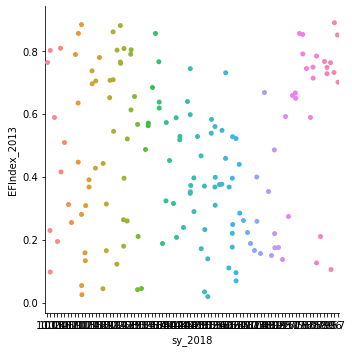

In [563]:
sns.catplot(data=sy_w_hief, x='sy_2018', y='EFIndex_2013')

#### Iteration #2: EFI 2013 vs SY 2013

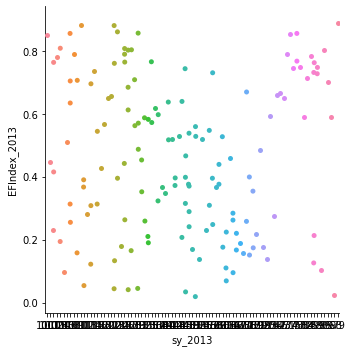

In [564]:
sns.catplot(data=sy_w_hief, x='sy_2013', y='EFIndex_2013')

# Analysis #3: EFI vs Exports + Imports (EI)

#### Iteration #1:  EFI 2013 vs EI 2018

#### Iteration #2: EFI 2013 vs EI 2013

In [320]:
##  Progress ends here

#### TO DO:

<ul>
    <li> Generate catplot graphs of every dataset after schooling_years:  follow the format I left behind and annotate the code
    <li> The final analysis of EFI vs WHR
        
When cleaning the WHR data, don't forget to alphabetize the countries by using .sort_values('Country') and reset their indexes using reset_index()